
# HRS Data Structuring + Initial Experiments

Key variables:
- `rnrshom`: Any overnight nursing home stay in reference period
- `rnrstim`: Number of nursing home stays
- `rnrsnit`: Number of nights over all stays

This is using "randhrs1992_2020v2_STATA/randhrs1992_2020v2_long_compact.pkl" which is in long format, where each row represents a respondent-wave observation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# load data
df = pd.read_pickle('randhrs1992_2020v2_STATA/randhrs1992_2020v2_long_compact.pkl')
print(f"Data shape: {df.shape}")
print("\nDataset Info:")
df.info()

Data shape: (636075, 1870)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636075 entries, 0 to 636074
Columns: 1870 entries, hhidpn to hinpovrd
dtypes: category(755), float32(5), float64(771), int32(4), int64(1), int8(15), object(319)
memory usage: 5.6+ GB



## 1. Data Exploration

In [16]:
nursing_vars = ['rnrshom', 'rnrstim', 'rnrsnit']

# whether a respondent had any nursing home stay in a wave
print(df.groupby('hhidpn')['rnrshom']
                   .apply(lambda x: (x == '1.yes').any())
                   .value_counts())

# number of nursing home stays in a wave
print(df.groupby('hhidpn')['rnrstim'] 
                   .apply(lambda x: (x > 0).any())
                   .value_counts())

# number of nights in nursing home in a wave
print(df.groupby('hhidpn')['rnrsnit'] 
                   .apply(lambda x: (x > 0).any())
                   .value_counts())

# Identify respondents and their waves
print("\nUnique respondents:", df['hhidpn'].nunique() if 'hhidpn' in df.columns else "hhidpn not found")
print("Waves in dataset:", sorted(df['wave'].unique()) if 'wave' in df.columns else "wave not found")

rnrshom
False    35927
True      6478
Name: count, dtype: int64
rnrstim
False    36091
True      6314
Name: count, dtype: int64
rnrsnit
False    36244
True      6161
Name: count, dtype: int64

Unique respondents: 42405
Waves in dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]



## 2. Creating Target Variables

### 2.1 First-time Nursing Home Admission

In [3]:
plt.style.use('default')  
sns.set_theme()  
plt.rcParams['figure.figsize'] = [10, 6]  
plt.rcParams['figure.dpi'] = 100  

Total number of respondents with any nursing home stay: 6478
Number with multiple stays: 2990
Percentage with multiple stays: 46.2%

Distribution of number of stays:
total_stays
0.0       165
1.0      3323
2.0      1465
3.0       705
4.0       367
5.0       169
6.0        91
7.0        52
8.0        32
9.0        10
10.0       12
11.0        5
12.0        9
13.0        4
14.0        2
15.0        4
16.0        3
17.0        1
18.0        1
20.0        4
21.0        2
23.0        1
24.0        1
26.0        3
27.0        3
28.0        1
30.0        1
31.0        2
32.0        1
33.0        1
36.0        2
37.0        2
38.0        1
40.0        1
45.0        1
50.0        1
52.0        1
57.0        1
62.0        1
74.0        1
75.0        1
76.0        1
90.0        3
91.0        1
95.0        4
96.0        1
97.0        1
98.0        4
99.0        1
100.0       3
101.0       2
102.0       1
103.0       1
108.0       1
109.0       1
Name: count, dtype: int64


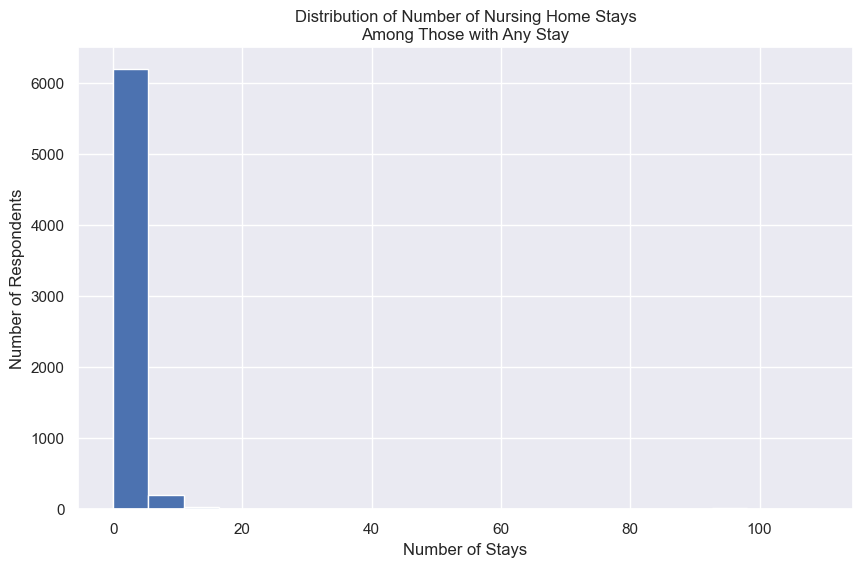

In [21]:
def analyze_multiple_admissions(df):
    """
    Analyze patterns of multiple nursing home admissions and discharges
    """
    # Group by respondent
    admission_patterns = []
    
    for hhidpn, person_data in df.groupby('hhidpn'):
        person_data = person_data.sort_values('wave')
        
        # Check if they ever had any admission
        had_any_admission = (person_data['rnrshom'] == '1.yes').any()
        
        if had_any_admission:
            # Count number of distinct admissions
            num_stays = person_data[person_data['rnrstim'] > 0]['rnrstim'].sum()
            
            admission_patterns.append({
                'hhidpn': hhidpn,
                'total_stays': num_stays,
                'had_multiple_stays': num_stays > 1
            })
    
    # Convert to DataFrame
    patterns_df = pd.DataFrame(admission_patterns)
    
    # Calculate statistics
    total_with_admissions = len(patterns_df)
    multiple_stays = patterns_df['had_multiple_stays'].sum()
    
    print(f"Total number of respondents with any nursing home stay: {total_with_admissions}")
    print(f"Number with multiple stays: {multiple_stays}")
    print(f"Percentage with multiple stays: {(multiple_stays/total_with_admissions)*100:.1f}%")
    
    # Distribution of number of stays
    print("\nDistribution of number of stays:")
    print(patterns_df['total_stays'].value_counts().sort_index())
    
    return patterns_df

# Run the analysis
patterns_df = analyze_multiple_admissions(df)

In [3]:
from tqdm import tqdm
import numpy as np

def create_prediction_dataset(df):
    """
    Identify first nursing home admission for each respondent and prepare prediction data
    """
    print("Starting prediction dataset creation...")
    
    # Sort by respondent ID and wave once
    df_sorted = df.sort_values(['hhidpn', 'wave'])
    
    # Initialize indicators
    df_sorted['first_admission'] = False
    df_sorted['will_admit_next'] = False
    
    # Pre-compute groups
    groups = dict(tuple(df_sorted.groupby('hhidpn')))
    
    # Initialize list for prediction data
    prediction_rows = []
    skipped_wave_0_admissions = 0
    skipped_single_wave_cases = 0
    
    # Process each respondent with progress bar
    for hhidpn in tqdm(groups.keys(), desc="Processing respondents"):
        group = groups[hhidpn]
        
        # Find first admission efficiently
        admission_mask = group['rnrshom'] == '1.yes'
        
        if admission_mask.any():
            # Get first admission wave
            first_admission_idx = admission_mask.idxmax()
            first_admission_wave = group.loc[first_admission_idx, 'wave']
            
            # Mark first admission
            df_sorted.loc[first_admission_idx, 'first_admission'] = True
            
            # Skip prediction if first admission is in wave 0
            if first_admission_wave == 0:
                skipped_wave_0_admissions += 1
                continue
                
            # Get wave before admission for prediction
            wave_before_mask = (group['wave'] == (first_admission_wave - 1))
            if wave_before_mask.any():
                wave_before = group[wave_before_mask].iloc[0].copy()
                wave_before['will_admit_next'] = True
                prediction_rows.append(wave_before)
        else:
            # For negative cases, get second-to-last wave if available
            if len(group) >= 2:
                second_to_last_wave = group.iloc[-2].copy()
                second_to_last_wave['will_admit_next'] = False
                prediction_rows.append(second_to_last_wave)
            else:
                skipped_single_wave_cases += 1
    
    # Create prediction dataset efficiently
    print("\nCompiling prediction dataset...")
    prediction_data = pd.DataFrame(prediction_rows)
    
    # Print summary statistics
    print("\nResults:")
    n_admissions = df_sorted['first_admission'].sum()
    n_pre_admission = prediction_data['will_admit_next'].sum()
    n_never_admitted = (~prediction_data['will_admit_next']).sum()
    
    print(f"Number of first-time admissions: {n_admissions}")
    print(f"Number of admissions in wave 0 (excluded from prediction): {skipped_wave_0_admissions}")
    print(f"Number of single-wave cases (excluded from prediction): {skipped_single_wave_cases}")
    print(f"Number of pre-admission waves: {n_pre_admission}")
    print(f"Number of never-admitted cases: {n_never_admitted}")
    print(f"Total cases for prediction: {len(prediction_data)}")
    
    # Calculate class balance
    pos_pct = (n_pre_admission / len(prediction_data)) * 100
    print(f"\nClass balance: {pos_pct:.1f}% positive cases (will admit next)")
    
    # Show wave distribution for both positive and negative cases
    print("\nWave distribution for pre-admission cases (positive):")
    pos_wave_dist = prediction_data[prediction_data['will_admit_next']]['wave'].value_counts().sort_index()
    print(pos_wave_dist)
    
    print("\nWave distribution for never-admitted cases (negative):")
    neg_wave_dist = prediction_data[~prediction_data['will_admit_next']]['wave'].value_counts().sort_index()
    print(neg_wave_dist)
    
    return df_sorted, prediction_data

df, prediction_df = create_prediction_dataset(df)

# Optional: Verify data structure
print("\nSample of prediction data:")
print(prediction_df[['hhidpn', 'wave', 'will_admit_next']].head())

# Optional: Data quality checks
print("\nData quality checks:")
print("Number of unique respondents:", len(prediction_df['hhidpn'].unique()))
print("Any missing values in key fields:", prediction_df[['hhidpn', 'wave', 'will_admit_next']].isnull().any().any())
print("Wave range:", prediction_df['wave'].min(), "to", prediction_df['wave'].max())

Starting prediction dataset creation...


Processing respondents: 100%|██████████| 42405/42405 [13:08<00:00, 53.76it/s]   



Compiling prediction dataset...

Results:
Number of first-time admissions: 6478
Number of admissions in wave 0 (excluded from prediction): 0
Number of single-wave cases (excluded from prediction): 0
Number of pre-admission waves: 6464
Number of never-admitted cases: 35927
Total cases for prediction: 42391

Class balance: 15.2% positive cases (will admit next)

Wave distribution for pre-admission cases (positive):
wave
1     130
2     453
3     535
4     465
5     532
6     474
7     502
8     512
9     659
10    559
11    546
12    459
13    356
14    282
Name: count, dtype: int64

Wave distribution for never-admitted cases (negative):
wave
14    35927
Name: count, dtype: int64

Sample of prediction data:
          hhidpn  wave  will_admit_next
551265      1010    14            False
551266      2010    14            False
551267      3010    14            False
424053      3020    11             True
551269  10001010    14            False

Data quality checks:
Number of unique respo

In [4]:
prediction_df

,hhidpn,inw1,shhidpn,sbmonth,sbyear,sbdate,sbflag,scohbyr,shrsamp,sahdsmp,...,hifssi,hifirawy1,hiftot2,hiiraw,hifiraw,hpovhhid,hinpovd,hinpovrd,first_admission,will_admit_next
551265,1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
551266,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
551267,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
424053,3020,NaN,3010.0,1.0,1936.0,-8752.0,0.mo/yr ok,3.hrs,"1.in samp,hrs92 resp b.1931-41",0.not in sample,...,6.no income,NaN,NaN,121000.0,1.no imputations,NaN,NaN,NaN,False,True
551269,10001010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593665,923525020,NaN,923525010.0,1.0,1957.0,-1081.0,0.mo/yr ok,6.mid babyboomers,0.not in sample,0.not in sample,...,6.no income,NaN,NaN,0.0,0.no income,NaN,NaN,NaN,False,False
593666,952836010,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.no income,NaN,NaN,0.0,0.no income,NaN,NaN,NaN,False,False
593667,958361010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
593668,959733010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [5]:
prediction_df.to_pickle('next_wave_admission_prediction.pkl')
df.to_pickle('randhrs1992_2020v2_STATA/randhrs1992_2020v2_long_compact_with_first_admission.pkl')

In [7]:
prediction_df

,hhidpn,inw1,shhidpn,sbmonth,sbyear,sbdate,sbflag,scohbyr,shrsamp,sahdsmp,...,hifssi,hifirawy1,hiftot2,hiiraw,hifiraw,hpovhhid,hinpovd,hinpovrd,first_admission,will_admit_next
593670,1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
593671,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
593672,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
424053,3020,NaN,3010.0,1.0,1936.0,-8752.0,0.mo/yr ok,3.hrs,"1.in samp,hrs92 resp b.1931-41",0.not in sample,...,6.no income,NaN,NaN,121000.0,1.no imputations,NaN,NaN,NaN,False,True
593674,10001010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636070,923525020,NaN,923525010.0,1.0,1957.0,-1081.0,0.mo/yr ok,6.mid babyboomers,0.not in sample,0.not in sample,...,2.complete bracket,NaN,NaN,0.0,0.no income,NaN,NaN,NaN,False,False
636071,952836010,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.dk if income,NaN,NaN,0.0,0.no income,NaN,NaN,NaN,False,False
636072,958361010,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.no income,NaN,NaN,0.0,0.no income,NaN,NaN,NaN,False,False
636073,959733010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False



## 3. Social Determinants of Health

Let's identify and analyze potential social determinants as predictors:
1. Demographics (age, gender, race/ethnicity)
2. Economic factors (income, wealth, employment)
3. Education
4. Social support (marital status, living arrangements)
5. Healthcare access
6. Health status
7. Neighborhood characteristics
8. Behavioral factors


In [ ]:

# Define categories of social determinants
social_determinants = {
    'Demographics': ['rage', 'ragender', 'raracem', 'rahispan'],
    'Economic': ['rtotinc', 'rtotasst', 'rfinpln', 'rwork'],
    'Education': ['raeduc', 'rschlyrs'],
    'Social Support': ['rmarst', 'rlivsib', 'rlivkids', 'rlivalone'],
    'Healthcare Access': ['rcovr', 'rdoctor', 'rhosp'],
    'Health Status': ['rcesd', 'rshlt', 'radla', 'riadla'],
    'Neighborhood': ['rhouser', 'rhouse'],
    'Behavioral': ['rsmoken', 'rdrink', 'rvig10mt']
}

# Check availability and completeness of predictors
print("Analyzing social determinants availability:")
available_predictors = []

for category, variables in social_determinants.items():
    print(f"\n{category}:")
    for var in variables:
        if var in df.columns:
            missing = df[var].isnull().sum()
            completeness = ((len(df) - missing) / len(df)) * 100
            print(f"{var}: {completeness:.1f}% complete")
            if completeness >= 90:  # Only include variables with ≥90% completeness
                available_predictors.append(var)
        else:
            print(f"{var}: Not found in dataset")

# Create correlation matrix for available numeric predictors
numeric_predictors = df[available_predictors].select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[list(numeric_predictors) + ['rnrshom']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Social Determinants and Nursing Home Admission')
plt.tight_layout()
plt.show()



## 4. Analysis Functions

Helper functions to explore relationships between variables:


In [ ]:

def analyze_predictor(df, predictor, target='rnrshom'):
    """Analyze relationship between a predictor and nursing home admission"""
    if predictor not in df.columns:
        print(f"Predictor {predictor} not found in dataset")
        return
    
    print(f"\nAnalyzing {predictor}:")
    
    # Calculate correlation if numeric
    if pd.api.types.is_numeric_dtype(df[predictor]):
        correlation = df[predictor].corr(df[target])
        print(f"Correlation with admission: {correlation:.3f}")
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=target, y=predictor)
        plt.title(f'{predictor} by Admission Status')
        plt.show()
    else:
        # For categorical variables
        contingency = pd.crosstab(df[predictor], df[target], normalize='index') * 100
        print("\nAdmission rates by category (%):\n", contingency[1])
        
        plt.figure(figsize=(10, 6))
        contingency[1].plot(kind='bar')
        plt.title(f'Admission Rate by {predictor}')
        plt.ylabel('Admission Rate (%)')
        plt.xticks(rotation=45)
        plt.show()

def analyze_temporal_patterns(df, predictor, target='rnrshom'):
    """Analyze how the relationship between predictor and admission changes over time"""
    if predictor not in df.columns:
        print(f"Predictor {predictor} not found in dataset")
        return
    
    # Calculate admission rates by predictor and wave
    if pd.api.types.is_numeric_dtype(df[predictor]):
        # For numeric predictors, create categories
        df['predictor_cat'] = pd.qcut(df[predictor], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
        temporal_patterns = df.groupby(['wave', 'predictor_cat'])[target].mean()
    else:
        temporal_patterns = df.groupby(['wave', predictor])[target].mean()
    
    # Plot temporal patterns
    plt.figure(figsize=(12, 6))
    temporal_patterns.unstack().plot(marker='o')
    plt.title(f'Admission Rates by {predictor} Over Time')
    plt.xlabel('Wave')
    plt.ylabel('Admission Rate')
    plt.legend(title=predictor)
    plt.grid(True)
    plt.show()

# Example usage:
print("Example analyses:")
print("1. To analyze a predictor:")
print("analyze_predictor(df, 'rage')")
print("\n2. To analyze temporal patterns:")
print("analyze_temporal_patterns(df, 'rage')")
